High-performance threshold (Quartile_3 of Sales Volume): 2402.25
high_performance
0    0.748
1    0.252
Name: Class proportion, dtype: float64

=== Random Forest — Holdout Performance ===
Accuracy:  0.780
Precision: 0.750
Recall:    0.231
F1-score:  0.353
ROC-AUC:   0.604
PR-AUC:    0.482

Confusion matrix (rows=true, cols=pred):
[[36  1]
 [10  3]]


Classification report:
              precision    recall  f1-score   support

           0      0.783     0.973     0.867        37
           1      0.750     0.231     0.353        13

    accuracy                          0.780        50
   macro avg      0.766     0.602     0.610        50
weighted avg      0.774     0.780     0.734        50

RF — CV ROC-AUC (mean ± sd): 0.527 ± 0.095

Top 12 Features — RF Gini Importance
desc_length    0.362615
name_length    0.269450
Price          0.255174
Promotion      0.045156
Seasonal       0.038690
Section        0.028916
dtype: float64

Top 12 Features — RF Permutation Importance (Holdout)
Se

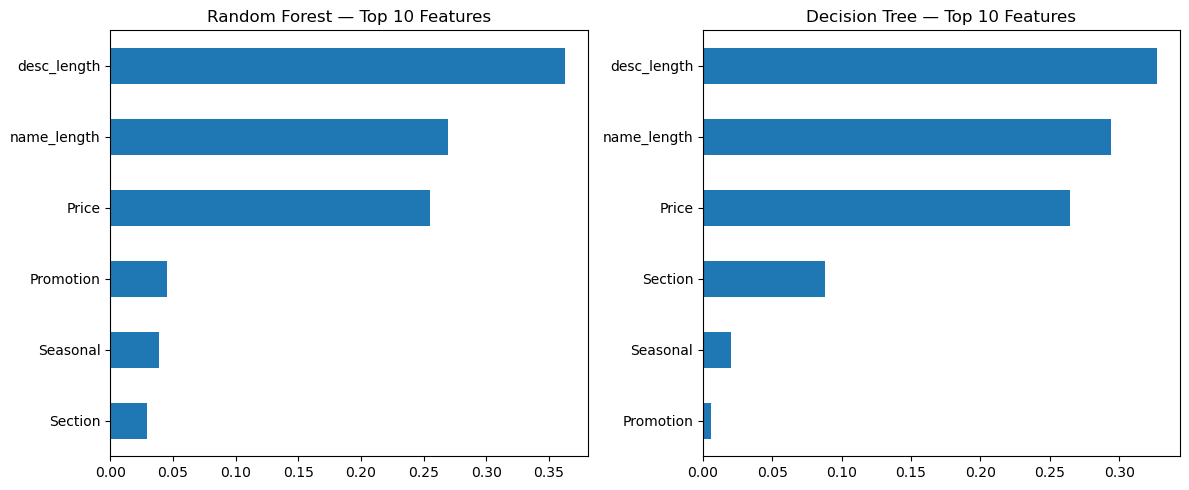

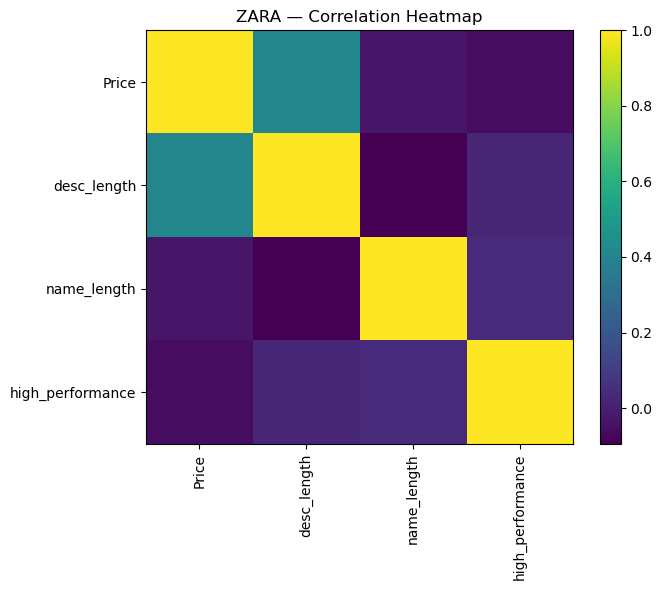

In [5]:
# ========================================= ZARA ==========================================

# The below code imports the required libraries.
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    average_precision_score
)
from sklearn.inspection import permutation_importance

# Loading the dataset from local system
Zara_file = r"C:\\Users\\ROHIT PAUL\\Desktop\\Dissertation Dataset\\ZARA.csv" 
zara_df = pd.read_csv(Zara_file)

# In this piece of code, we are defining the target from sales volume.
if "Sales Volume" not in zara_df.columns:
    raise ValueError("Expected 'Sales Volume' to create the target.") # This statement ensures the column required to build the target exists.

quartile_3 = zara_df["Sales Volume"].quantile(0.75) # This line calculates the Q3 (75th percentile) of Sales Volume.
# Here, we are creating a binary target, 1 if Sales Volume >= Q3 else 0.
zara_df["high_performance"] = (zara_df["Sales Volume"] >= quartile_3).astype(int)
print(f"High-performance threshold (Quartile_3 of Sales Volume): {quartile_3:.2f}") # This line prints the numeric threshold used.
# The below piece of prints the class imbalance as proportions.
print(zara_df["high_performance"].value_counts(normalize=True).rename("Class proportion"))


# Keeping only the relevant predictors 
relevant_list = {
    "Price","Product Category","Category","Promotion","Seasonal","Section","Brand",
    "Color","Size","Material","Fit","Style","Pattern","Length","Occasion",
    "Rating","Ratings","Review Count","Reviews","Sentiment","Sentiment Score","Season"
}
# The below piece of code starts from all columns except the target label and original Sales Volume
items = [c for c in zara_df.columns if c not in ["high_performance", "Sales Volume"]]
blacklist_columns = re.compile(r"(scrap|terms?|url|link|sku|barcode|image|img|thumb|photo|uuid|guid|^id$|^id_|_id$|timestamp|created|updated)", re.I)
items = [c for c in items if not blacklist_columns.search(c)]

relevant_columns = [c for c in items if c in relevant_list or any(w.lower() in c.lower() for w in relevant_list)]

# Optional text-length signals
if "Description" in zara_df.columns:
    zara_df["desc_length"] = zara_df["Description"].astype(str).str.len()
    relevant_columns.append("desc_length")
if "Name" in zara_df.columns:
    zara_df["name_length"] = zara_df["Name"].astype(str).str.len()
    relevant_columns.append("name_length")

# Fallback if empty
if not relevant_columns:
    for c in items:
        if zara_df[c].dtype == object and zara_df[c].astype(str).str.len().median() > 60:
            continue
        relevant_columns.append(c)

# This piece of code drops the constant columns
relevant_columns = [c for c in relevant_columns if zara_df[c].nunique(dropna=True) > 1] # This line removes any columns which has only one value

# Build X / y 
# Input features
X = zara_df[relevant_columns].copy()
# Output labels
y = zara_df["high_performance"].astype(int)

# Train/test split 
# In the below snippet, we are spliting the data into train (80%) and test (20%) while keeping the class ratios similar.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# The below code identify column types on the TRAINING set ( numeric or categorical)
num_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_columns = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocess inside ColumnTransformer (prevents leakage)
# Here we build a transformer which imputes and encodes properly for each type.
preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_columns), # Here, we are filling missing numeric values with median.
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")), # Here, we are filling missing categorical values with median.
            ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_columns),
    ],
    remainder="drop"
)

# Convenience: feature names after transform (ColumnTransformer keeps order)
feature_name_01 = list(num_columns) + list(cat_columns)

# In the below code, a method has been created to print all the key metrics
def method_output(model_name, y_true, y_pred, y_proba):
    acc  = accuracy_score(y_true, y_pred) # This line calculates the overall percentage of correct predictions.
    prec = precision_score(y_true, y_pred, zero_division=0) # This line checks out of predictive positive, how many are true positives.
    rec  = recall_score(y_true, y_pred, zero_division=0) # This line checks how many truly positive items did we captured.
    f1   = f1_score(y_true, y_pred, zero_division=0) # Balance between precision and recall.
    auc  = roc_auc_score(y_true, y_proba) 
    avg_p   = average_precision_score(y_true, y_proba) # It is for PR-AUC

# The below piece of code prints the summary of the performance.
    print(f"\n=== {model_name} — Holdout Performance ===")
    print(f"Accuracy:  {acc:.3f}") # This piece of code prints the accuracy of the model
    print(f"Precision: {prec:.3f}") # This piece of code prints the precision of the model
    print(f"Recall:    {rec:.3f}") # This piece of code prints the recall value of the model
    print(f"F1-score:  {f1:.3f}") # This piece of code prints the F1-score of the model
    print(f"ROC-AUC:   {auc:.3f}") # This piece of code prints the ROC-AUC of the model
    print(f"PR-AUC:    {avg_p:.3f}") # This piece of code prints the PR-AUC of the model
    print() # This code adds a blank line
# The below piece of code shows count of true/false positive/negatives.
    print("Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_true, y_pred))
    print() # This code adds a blank line
# The below snippet prints per-class precision/recall/F1 plus macro/weighted averages.
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

# The below piece of code builds a pipeline - processing first, and then fitting the Random Forest model
random_forest_m = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=600, random_state=42,
        class_weight="balanced_subsample", n_jobs=-1
    ))
])
random_forest_m.fit(X_train, y_train) # Here we are training the model on the training split.
y_prob_rf = random_forest_m.predict_proba(X_test)[:, 1]
y_hat_rf  = (y_prob_rf >= 0.5).astype(int)
method_output("Random Forest", y_test, y_hat_rf, y_prob_rf) # This line prints all the mtrtrics of Random Forest.

# CV ROC-AUC for Random Forest
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # This line of code sets up a 5-fold stratified cross-validation filter.
cv_rf = cross_val_score(random_forest_m, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)# This line evaluates the ROC-AUC across folds using full pipeline.
# the below piece displays meand and standard deviation of Cross-Validation performance.
print("RF — CV ROC-AUC (mean ± sd): %.3f ± %.3f" % (cv_rf.mean(), cv_rf.std()))

# Feature Importances 
# The below piece of code pulls out the built in Feature Importances from the fitted Random Forest.
randomforest_fi = pd.Series(
    random_forest_m.named_steps["clf"].feature_importances_,
    index=feature_name_01
).sort_values(ascending=False)
print("\nTop 12 Features — RF Gini Importance") # This line of code displays the top 12 most important features 
print(randomforest_fi.head(12))

# Permutation importance on holdout
# The below code evaluates feature importance by measuring performance drop when a feature is shuffled.
perm_rf = permutation_importance(random_forest_m, X_test, y_test, n_repeats=12, random_state=42, n_jobs=-1)
perm_rf_s = pd.Series(perm_rf.importances_mean, index=feature_name_01).sort_values(ascending=False) # This line of code turns the result into a sorted series.
print("\nTop 12 Features — RF Permutation Importance (Holdout)") # This line of code displays the top 12 features by permutation importance
print(perm_rf_s.head(12))

# Modelling Decision Tree as benchmark model
# Here, we are building another pipeline - a single and shallow tree.
dtree = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced"))
])
dtree.fit(X_train, y_train) # This line trains the decision tree.
y_prob_dt = dtree.predict_proba(X_test)[:, 1] # This code gets the probability for positive class on the test data.
y_hat_dt  = (y_prob_dt >= 0.5).astype(int) # This code convert the probabilities into labels with a 0.5 threshold.
# The below code print metrics for the Decision Tree model.
method_output("Decision Tree (max_depth=5)", y_test, y_hat_dt, y_prob_dt)

# CV ROC-AUC for Decision Tree.
# The below code is cross-validating the Decision Tree.
cv_dt = cross_val_score(dtree, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print("DT — CV ROC-AUC (mean ± sd): %.3f ± %.3f" % (cv_dt.mean(), cv_dt.std())) # This line displays the mean and spread of CV ROC-AUC.

# Decision Tree Feature Importance.
# The below snippet of code captures the feature importance from the Decision Tree and sort them.
dtree_fi = pd.Series(
    dtree.named_steps["clf"].feature_importances_,
    index=feature_name_01
).sort_values(ascending=False)
print("\nTop 12 Features — Decision Tree Importance") # This piece of code shows the top 12 important features for the tree.
print(dtree_fi.head(12))

# Comparing Top-10 importances for both models
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # This line sets up a side-by-side plot area.
# The below code plots the top 10 most important features of RF
randomforest_fi.head(10).iloc[::-1].plot.barh(ax=axes[0], title="Random Forest — Top 10 Features")
# The below code plots the top 10 most important features of DT
dtree_fi.head(10).iloc[::-1].plot.barh(ax=axes[1], title="Decision Tree — Top 10 Features")
plt.tight_layout()
plt.show() # This line displays the plots

# Correlation Heatmap 
corr_df = pd.concat([X_train[num_columns], y_train], axis=1) if len(num_columns) else pd.DataFrame()
if not corr_df.empty and corr_df.shape[1] >= 2: # This line makes sure to proceed with correlation if there are a minimum of 2 columns to correlate.
    corr = corr_df.corr() # This line computes the correlation matrix.
    plt.figure(figsize=(7, 6)) # This line creates heatmap figure.
    im = plt.imshow(corr, aspect="auto")
    plt.title("ZARA — Correlation Heatmap") # This displays the titile of the plot.
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90) # Labelling the X-axis.
    plt.yticks(range(len(corr.index)), corr.index) # Labelling the Y-axis.
    plt.colorbar(im) # This line adds a color bar for reference.
    plt.tight_layout()
    plt.show() # Displaying the heatmap.
else:
    print("\n[Heatmap] Not enough raw numeric variables to plot.") # This message is shown if there are insufficient numeric columns.
